<p align="center">
  <img width="300" height="290" src="https://i.imgur.com/mu6ZuGT.jpg">
</p>

<h1><b>TC4033</b></h1>
<h1><b>Visión computacional para imágenes y video</b></h1>
<h3><b>7.2 Google Colab algoritmos de extracción de características</b></h3>
<h3><b>a)Harris Corner Detection </b></h3>
<h3><b>Docentes:</b> Dr. Gilberto Ochoa Ruiz, Mtra. María Guadalupe Marcos Abularach</h3>

<h2><b>Equipo 30:</b></h2>

- Julio Baltazar Colín: A01794476
- Helmy Andrea Moreno Navarro: A01793918
- Maricel Parra Osorio - A01793932
- Yeison Fernando Villamil Franco: A01793803


# 7. Harris Edge & Corner Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Color image to Grayscale conversion](#grayscale)
3. [Spatial derivative calculation](#spatial)
4. [Structure tensor setup](#tensor)
5. [Harris response calculation](#response)
6. [Find edges and corners using R](#find)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [100]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage.filters import convolve

<ipython-input-100-2a3762aac77b>:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


## 1. Color to Grayscale <a class="anchor" id="grayscale" ></a>

In [101]:
from io import BytesIO
import requests
def imagen_desde_url(url):
  response = requests.get(url)
  img_data = BytesIO(response.content)

  # Convertir los datos a una matriz de imagen
  image = cv2.imdecode(np.frombuffer(img_data.read(), np.uint8), 1)

  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

  return image

In [102]:
def display_images(image_dict, nrow, ncol, xsz=15, ysz=7,):
    """
    Muestra imágenes en un diccionario en una cuadrícula de subplots.

    Parámetros:
    - image_dict: Diccionario de imágenes donde las claves son los títulos de las imágenes y los valores son las propias imágenes.
    - nrow: Número de filas en la cuadrícula de subplots.
    - ncol: Número de columnas en la cuadrícula de subplots.
    - xsz: Tamaño del plot en el eje x.
    - ysz: Tamaño del plot en el eje y.
    - hspace: Espacio vertical entre los subplots.
    """

    fig, axes = plt.subplots(nrow, ncol, figsize=(xsz, ysz))

    # Ajustar el espaciado entre subplots
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.6, wspace=0.1, hspace=0.1)

    # Iterar sobre el diccionario de imágenes y mostrar en subplots
    for (title, image), ax in zip(image_dict.items(), axes.ravel()):
        ax.imshow(image, cmap='gray')  # Mostrar la imagen en escala de grises
        ax.set_title(title)  # Establecer el título del subplot
        ax.set_xticks([])  # Remover las escalas numéricas del eje x
        ax.set_yticks([])  # Remover las escalas numéricas del eje y

    # Ocultar subplots restantes si hay menos imágenes que subplots
    for ax in axes.ravel()[len(image_dict):]:
        ax.axis('off')

    plt.show()

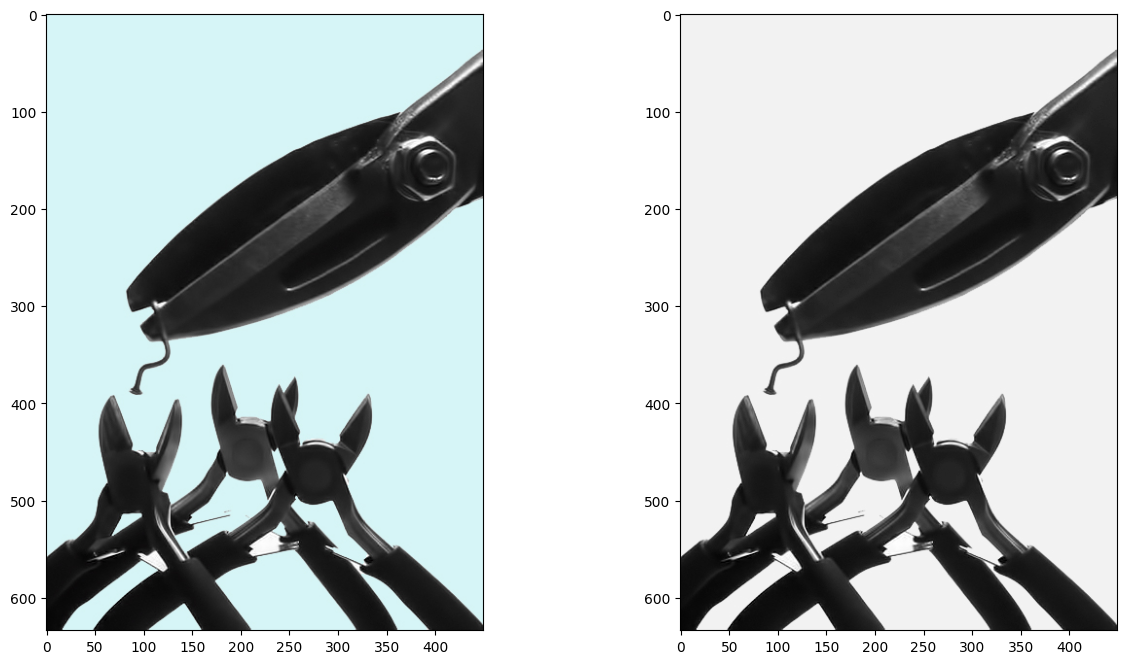

In [103]:
img = imagen_desde_url('https://github.com/yeivillamil/Team30_CV/blob/main/data/semana_7/Pinza.jpg?raw=true')
img_color = img
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 2. Spatial derivative calculation <a class="anchor" id="spatial" ></a>

In [104]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

## 3. Structure tensor setup <a class="anchor" id="tensor" ></a>

In [105]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

## 4. Harris response calculation <a class="anchor" id="response" ></a>

In [106]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy

harris_response = detA - k * traceA ** 2

In [107]:
img_gray.shape

(634, 450)

In [108]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [109]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

## 5. Find edges and corners using R <a class="anchor" id="find" ></a>

In [110]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

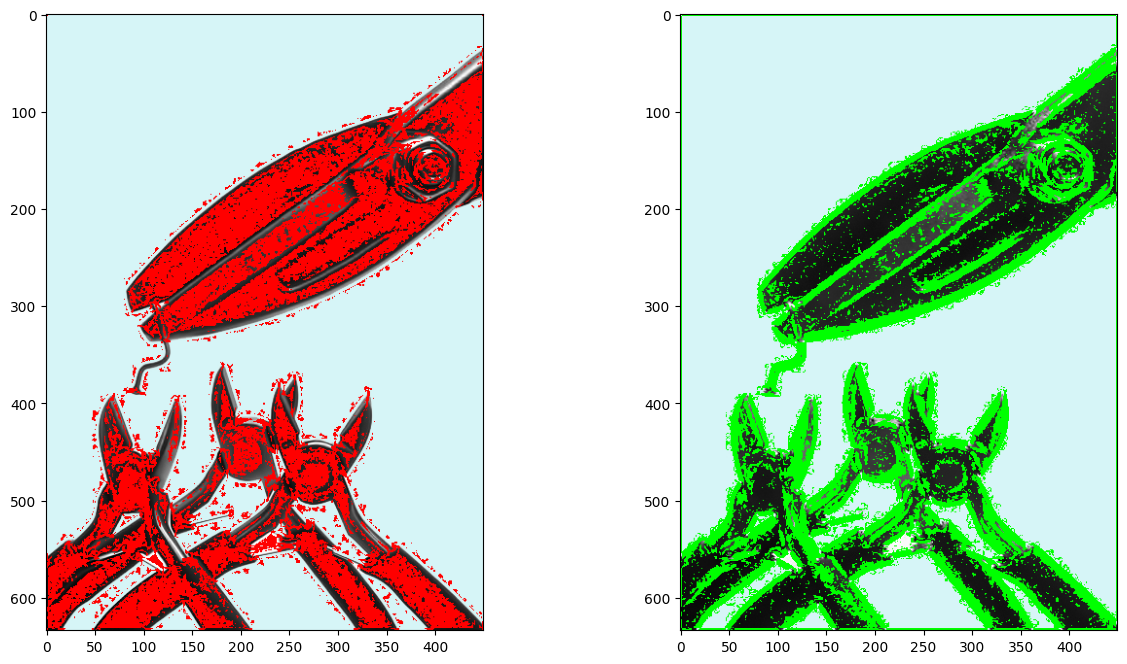

In [111]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

 a) En el Collab de Harris Detector, se sugiere que se hagan pruebas con imágenes propias que el equipo decida usar. La idea  es escoger un objeto y tomar fotos con diferentes tipos de iluminación (bajo el sol, en un lugar oscuro) y bajo diferentes ángulos para analizar el comportamiento del detector de Harris bajo diferentes settings

In [121]:
def aplicar_harris(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    I_x = gradient_x(img_gray)
    I_y = gradient_y(img_gray)
    Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
    Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
    Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

    k = 0.05

    # determinante
    detA = Ixx * Iyy - Ixy ** 2

    # trace
    traceA = Ixx + Iyy

    harris_response = detA - k * traceA ** 2

    img_copy_for_corners = np.copy(img)
    img_copy_for_edges = np.copy(img)

    height, width = img_gray.shape
    offset = 1  # Tamaño de la ventana a considerar

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            if harris_response[y, x] > 0:  # Esquina
                img_copy_for_corners[y, x] = [255, 0, 0]
            elif harris_response[y, x] < 0:  # Borde
                img_copy_for_edges[y, x] = [0, 255, 0]

    return img_copy_for_corners, img_copy_for_edges


In [124]:
img = imagen_desde_url('https://github.com/yeivillamil/Team30_CV/blob/main/data/semana_7/Ventanal.jpg?raw=true')
# Aplicar el algoritmo de Harris a la imagen
esquinas, bordes = aplicar_harris(img)

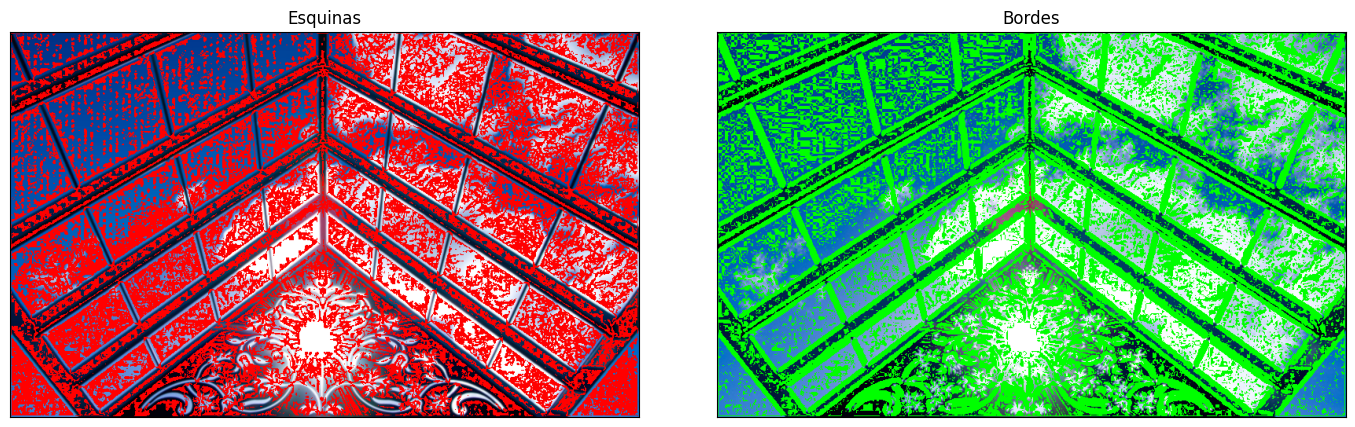

In [126]:
img_dict = {
     "Esquinas": esquinas
    ,"Bordes":  bordes
}

display_images(img_dict, 1,2)